In [1]:
%matplotlib inline


# Multi instrument joint 3D and 1D analysis

Joint 3D analysis using 3D Fermi datasets, a H.E.S.S. reduced spectrum and HAWC flux points.

## Prerequisites

-  Handling of Fermi-LAT data with Gammapy see the :doc:`/tutorials/data/fermi_lat` tutorial.
-  Knowledge of spectral analysis to produce 1D On-Off datasets, see
   the following :doc:`/tutorials/analysis-1d/spectral_analysis` tutorial.
-  Using flux points to directly fit a model (without forward-folding) from the 
   :doc:`/tutorials/analysis-1d/sed_fitting` tutorial.

## Context

Some science studies require to combine heterogeneous data from various
instruments to extract physical information. In particular, it is often
useful to add flux measurements of a source at different energies to an
analysis to better constrain the wide-band spectral parameters. This can
be done using a joint fit of heterogeneous datasets.

**Objectives: Constrain the spectral parameters of the gamma-ray
emission from the Crab nebula between 10 GeV and 100 TeV, using a 3D
Fermi dataset, a H.E.S.S. reduced spectrum and HAWC flux points.**

## Proposed approach

This tutorial illustrates how to perform a joint modeling and fitting of
the Crab Nebula spectrum using different datasets. The spectral
parameters are optimized by combining a 3D analysis of Fermi-LAT data, a
ON/OFF spectral analysis of HESS data, and flux points from HAWC.

In this tutorial we are going to use pre-made datasets. We prepared maps
of the Crab region as seen by Fermi-LAT using the same event selection
than the [3FHL catalog](https://arxiv.org/abs/1702.00664)_ (7 years of
data with energy from 10 GeV to 2 TeV). For the HESS ON/OFF analysis we
used two observations from the [first public data
release](https://arxiv.org/abs/1810.04516)_ with a significant signal
from energy of about 600 GeV to 10 TeV. These observations have an
offset of 0.5° and a zenith angle of 45-48°. The HAWC flux points data
are taken from a [recent
analysis](https://arxiv.org/pdf/1905.12518.pdf)_ based on 2.5 years of
data with energy between 300 Gev and 300 TeV.

## The setup


In [40]:
from pathlib import Path
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.maps import MapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import Models, create_crab_spectral_model

## Check setup



In [6]:
%env GAMMAPY_DATA=/home/hpc/caph/mppi086h/woody/software/gammapy-tutorials/gammapy-datasets/1.0
from gammapy.utils.check import check_tutorials_setup
from gammapy.utils.scripts import make_path

check_tutorials_setup()

env: GAMMAPY_DATA=/home/hpc/caph/mppi086h/woody/software/gammapy-tutorials/gammapy-datasets/1.0

System:

	python_executable      : /home/hpc/caph/mppi086h/wecap/software/anaconda3/envs/gammapy-1.0/bin/python 
	python_version         : 3.9.15     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.0        
	path                   : /home/hpc/caph/mppi086h/wecap/software/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.23.5     
	scipy                  : 1.9.1      
	astropy                : 5.1.1      
	regions                : 0.6        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.4.0      
	jupyterlab             : 3.4.8      
	matplotlib             : 3.6.2      
	pandas                 : 1.5.0      
	healpy                 : 1.16.1     
	iminuit                : 2.17.0     
	sherpa       

## Data and models files

The datasets serialization produce YAML files listing the datasets and
models. In the following cells we show an example containning only the
Fermi-LAT dataset and the Crab model.

Fermi-LAT-3FHL_datasets.yaml:




In [6]:
path = make_path("$GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_datasets.yaml")

with path.open("r") as f:
    print(f.read())

datasets:
- name: Fermi-LAT
  type: MapDataset
  filename: Fermi-LAT-3FHL_data_Fermi-LAT.fits



We used as model a point source with a log-parabola spectrum. The
initial parameters were taken from the latest Fermi-LAT catalog
[4FGL](https://arxiv.org/abs/1902.10045)_, then we have re-optimized
the spectral parameters for our dataset in the 10 GeV - 2 TeV energy
range (fixing the source position).

Fermi-LAT-3FHL_models.yaml:




In [7]:
path = make_path("$GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_models.yaml")

with path.open("r") as f:
    print(f.read())

components:
-   name: Crab Nebula
    type: SkyModel
    spectral:
        type: LogParabolaSpectralModel
        parameters:
        -   name: amplitude
            value: 0.018182745349064267
            unit: cm-2 s-1 TeV-1
            min: .nan
            max: .nan
            frozen: false
            error: 0.003026327991562108
        -   name: reference
            value: 5.054833602905273e-05
            unit: TeV
            min: .nan
            max: .nan
            frozen: true
            error: 0.0
        -   name: alpha
            value: 1.652368617859867
            unit: ''
            min: .nan
            max: .nan
            frozen: false
            error: 0.05762513693893088
        -   name: beta
            value: 0.03921700077803329
            unit: ''
            min: .nan
            max: .nan
            frozen: false
            error: 0.00521472221220211
    spatial:
        type: PointSpatialModel
        frame: icrs
        parameters:
        -   

## Reading different datasets

### Fermi-LAT 3FHL: map dataset for 3D analysis

For now we let’s use the datasets serialization only to read the 3D
`MapDataset` associated to Fermi-LAT 3FHL data and models.




In [67]:
path = Path("$GAMMAPY_DATA/fermi-3fhl-crab")
filename = path / "Fermi-LAT-3FHL_datasets.yaml"

datasets = Datasets.read(filename=filename)

models = Models.read(path / "Fermi-LAT-3FHL_models.yaml")
print(models)

Models

Component 0: SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.82e-02   +/- 3.0e-03 1 / (cm2 s TeV)
    reference             (frozen):      0.000       TeV         
    alpha                         :      1.652   +/-    0.06             
    beta                          :      0.039   +/-    0.01             
    lon_0                 (frozen):     83.633       deg         
    lat_0                 (frozen):     22.020       deg         

Component 1: FoVBackgroundModel

  Name                      : Fermi-LAT-bkg
  Datasets names            : ['Fermi-LAT']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.300   +/-    0.08             
    tilt                  (frozen):      0.000         

We get the Crab model in order to share it with the other datasets




In [9]:
print(models["Crab Nebula"])

SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.82e-02   +/- 3.0e-03 1 / (cm2 s TeV)
    reference             (frozen):      0.000       TeV         
    alpha                         :      1.652   +/-    0.06             
    beta                          :      0.039   +/-    0.01             
    lon_0                 (frozen):     83.633       deg         
    lat_0                 (frozen):     22.020       deg         




### HESS-DL3: 1D ON/OFF dataset for spectral fitting

The ON/OFF datasets can be read from PHA files following the [OGIP
standards](https://heasarc.gsfc.nasa.gov/docs/heasarc/ofwg/docs/spectra/ogip_92_007/node5.html)_.
We read the PHA files from each observation, and compute a stacked
dataset for simplicity. Then the Crab spectral model previously defined
is added to the dataset.




In [68]:
datasets_hess = Datasets()

for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.read(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets_hess.append(dataset)

dataset_hess = datasets_hess.stack_reduce(name="HESS")

datasets.append(dataset_hess)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : 




### HAWC: 1D dataset for flux point fitting

The HAWC flux point are taken from https://arxiv.org/pdf/1905.12518.pdf
Then these flux points are read from a pre-made FITS file and passed to
a `FluxPointsDataset` together with the source spectral model.




In [69]:
# read flux points from https://arxiv.org/pdf/1905.12518.pdf
filename = "$GAMMAPY_DATA/hawc_crab/HAWC19_flux_points.fits"
flux_points_hawc = FluxPoints.read(
    filename, reference_model=create_crab_spectral_model("meyer")
)

dataset_hawc = FluxPointsDataset(data=flux_points_hawc, name="HAWC")

datasets.append(dataset_hawc)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : HAWC
  Instrument : 
  Models     : 




### LHAASO: 1D dataset for flux point fitting

The LHAASO flux point are taken from https://arxiv.org/pdf/2111.06545.pdf
Then these flux points are read from a pre-made csv file and passed to
a `FluxPointsDataset` together with the source spectral model.




In [70]:
# read flux points from https://arxiv.org/pdf/1905.12518.pdf
filename = "./crab-3datasets/FluxPoints_lhaaso2021_km2a.dat"
flux_points_LHAASO = FluxPoints.read(
    filename, reference_model=create_crab_spectral_model("meyer")
)

# Add 10% systematic error
errn_sq = flux_points_LHAASO.dnde_errn.quantity**2 + (0.1*flux_points_LHAASO.dnde_ref)**2
errn_new = np.sqrt(errn_sq) / flux_points_LHAASO.dnde_ref
flux_points_LHAASO._data['norm_errn'].data = errn_new.to_value('')

errp_sq = flux_points_LHAASO.dnde_errp.quantity**2 + (0.1*flux_points_LHAASO.dnde_ref)**2
errp_new = np.sqrt(errp_sq) / flux_points_LHAASO.dnde_ref
flux_points_LHAASO._data['norm_errp'].data = errp_new.to_value('')

dataset_LHAASO = FluxPointsDataset(data=flux_points_LHAASO, name="LHAASO")

datasets.append(dataset_LHAASO)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : HAWC
  Instrument : 
  Models     : 

Dataset 3: 

  Type       : FluxPointsDataset
  Name       : LHAASO
  Instrument : 
  Models     : 




## Datasets serialization

The `datasets` object contains each dataset previously defined. It can
be saved on disk as datasets.yaml, models.yaml, and several data files
specific to each dataset. Then the `datasets` can be rebuild later
from these files.




In [71]:
path = Path("crab-3datasets")
path.mkdir(exist_ok=True)

filename = path / "crab_10GeV_100TeV_datasets.yaml"

datasets.write(filename, overwrite=True)

datasets = Datasets.read(filename)
datasets.models = models

print(datasets)

HDU 'MASK_FIT' not found
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : ['Crab Nebula', 'Fermi-LAT-bkg']

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : ['Crab Nebula']

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : HAWC
  Instrument : 
  Models     : ['Crab Nebula']

Dataset 3: 

  Type       : FluxPointsDataset
  Name       : LHAASO
  Instrument : 
  Models     : ['Crab Nebula']




## Joint analysis

We run the fit on the `Datasets` object that include a dataset for
each instrument




In [72]:
fit_joint = Fit()
results_joint = fit_joint.run(datasets=datasets)
print(results_joint)

HDU 'MASK_FIT' not found


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 374
	total stat : -12649.79

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



Let’s display only the parameters of the Crab spectral model




In [73]:
crab_spec = datasets[0].models["Crab Nebula"].spectral_model
print(crab_spec)

LogParabolaSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 2.0422e-03 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 5.0548e-05            TeV ... nan   True   False     
spectral     alpha 1.0945e+00                ... nan  False   False     
spectral      beta 7.1127e-02                ... nan  False   False     


We can compute flux points for Fermi-LAT and HESS datasets in order plot
them together with the HAWC flux point.




In [74]:
# compute Fermi-LAT and HESS flux points
energy_edges = MapAxis.from_energy_bounds("10 GeV", "2 TeV", nbin=5).edges

flux_points_fermi = FluxPointsEstimator(
    energy_edges=energy_edges,
    source="Crab Nebula",
).run([datasets["Fermi-LAT"]])


energy_edges = MapAxis.from_bounds(1, 15, nbin=6, interp="log", unit="TeV").edges

flux_points_hess = FluxPointsEstimator(
    energy_edges=energy_edges, source="Crab Nebula", selection_optional=["ul"]
).run([datasets["HESS"]])

In [84]:
flux_points_hess.write('crab-3datasets/FluxPoints_hess.fits', overwrite=True)
flux_points_fermi.write('crab-3datasets/FluxPoints_fermi.fits', overwrite=True)

Now, Let’s plot the Crab spectrum fitted and the flux points of each
instrument.




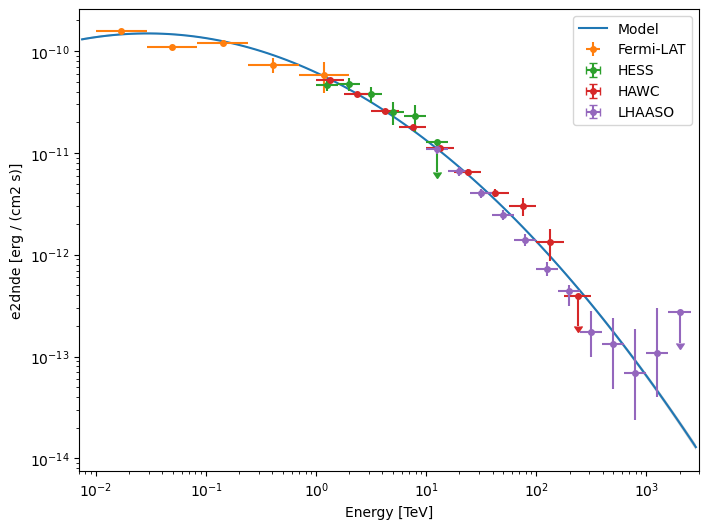

In [78]:
# display spectrum and flux points
fig, ax = plt.subplots(figsize=(8, 6))

energy_bounds = [0.007, 3e3] * u.TeV
sed_type = "e2dnde"

crab_spec.plot(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, label="Model")
crab_spec.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)

flux_points_fermi.plot(ax=ax, sed_type=sed_type, label="Fermi-LAT")
flux_points_hess.plot(ax=ax, sed_type=sed_type, label="HESS")
flux_points_hawc.plot(ax=ax, sed_type=sed_type, label="HAWC")
flux_points_LHAASO.plot(ax=ax, sed_type=sed_type, label="LHAASO")

ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

In [76]:
print(datasets['LHAASO'])

FluxPointsDataset
-----------------

  Name                            : LHAASO 

  Number of total flux points     : 12 
  Number of fit bins              : 11 

  Fit statistic type              : chi2
  Fit statistic value (-2 log(L)) : 21.44

  Number of models                : 1 
  Number of parameters            : 6
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : Crab Nebula
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      amplitude                     :   2.04e-03   +/- 1.5e-04 1 / (cm2 s TeV)
      reference             (frozen):      0.000       TeV         
      alpha                         :      1.095   +/-    0.02             
      beta                          :      0.071   +/-    0.00             
      lon_0                 (frozen):     83.633       deg         
      